## GSE182117 – disrupted circadian oscillations in type 2 diabetes

- Transcriptional cycling of core-clock genes BMAL1, CLOCK, and PER3 was altered in skeletal muscle from individuals with T2D, and this was coupled with reduced number and amplitude of cycling genes and disturbed circadian oxygen consumption.
- https://pmc.ncbi.nlm.nih.gov/articles/PMC8528429/

In [3]:
import COFE.analyse
import COFE.scpca
import COFE.plot
import numpy as np
import anndata as ad
import pandas as pd
import PCA_func as pc
import matplotlib.pyplot as plt
from umap import UMAP

### Step 1: Open the dataset

In [4]:
path = '/Users/maksimsgolubovics/Python_VScode/Studienprojekt/rnaseq_datasets/GSE182117_rnaseq.h5ad'
adata = ad.read_h5ad(path)

#Transform to DataFrame
data_df = pd.DataFrame(data=adata.X, columns=adata.var.index, index=adata.obs.index).T

#Look at sampeles features
adata.var[['disease', 'treatment', 'group', 'time', 'subject']]


,disease,treatment,group,time,subject
GSM5518711,NGT,CTL,NGT_CTL,12,i11
GSM5518712,NGT,CTL,NGT_CTL,24,i11
GSM5518713,NGT,CTL,NGT_CTL,36,i11
GSM5518714,NGT,CTL,NGT_CTL,48,i11
GSM5518715,NGT,HGI,NGT_HGI,12,i11
...,...,...,...,...,...
GSM5518892,NGT,CTL,NGT_CTL,54,i08
GSM5518893,NGT,HGI,NGT_HGI,12,i08
GSM5518894,NGT,HGI,NGT_HGI,24,i08
GSM5518895,NGT,HGI,NGT_HGI,36,i08


### Step 2: Prepare the dataset

In [5]:
data_df_log = np.log10(data_df + 0.1) #Logarithmic transformation

### Step 3: Exploratory analysis

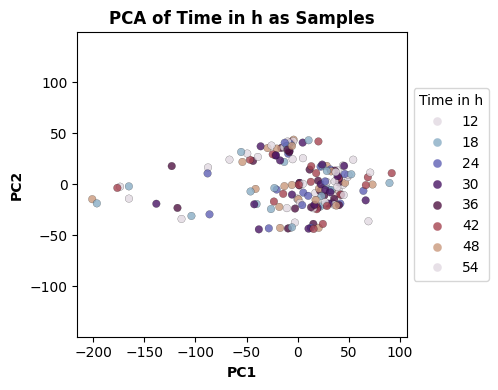

In [6]:
data_df_log_time = data_df_log.join(adata.var['time']).reset_index().set_index('time').drop('index', axis=1)
pc.principal_component_2d_timesample(data=data_df_log_time, label='Time in h', c_map='twilight')

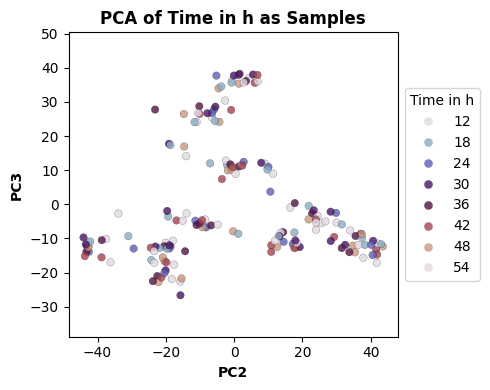

In [15]:
pc.principal_component_2d_timesample(data=data_df_log_time, x=2, y=3, label='Time in h', c_map='twilight')

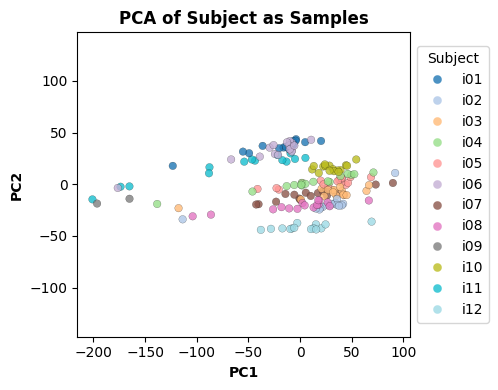

In [23]:
data_df_log_subject = data_df_log.join(adata.var['subject']).reset_index().set_index('subject').drop('index', axis=1)
pc.principal_component_2d_timesample(data=data_df_log_subject, label='Subject', c_map='tab20')

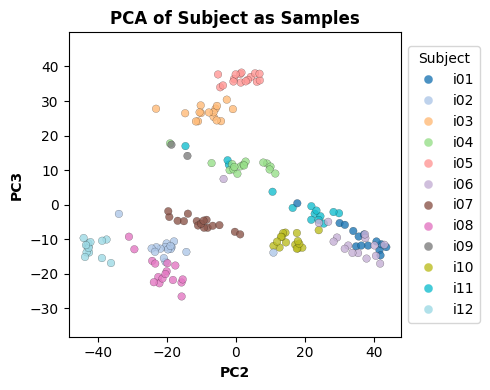

In [24]:
data_df_log_subject = data_df_log.join(adata.var['subject']).reset_index().set_index('subject').drop('index', axis=1)
pc.principal_component_2d_timesample(data=data_df_log_subject, x=2, y=3, label='Subject', c_map='tab20')

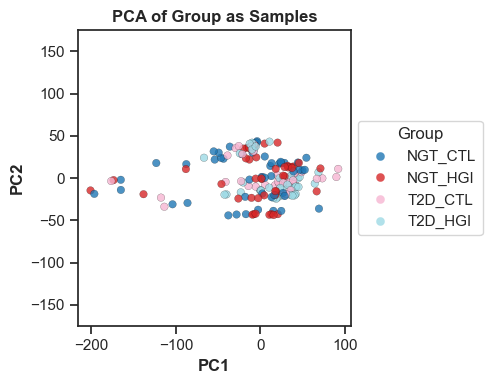

In [19]:
data_df_log_group = data_df_log.join(adata.var['group']).reset_index().set_index('group').drop('index', axis=1)
pc.principal_component_2d_timesample(data=data_df_log_group, label='Group', c_map='tab20')

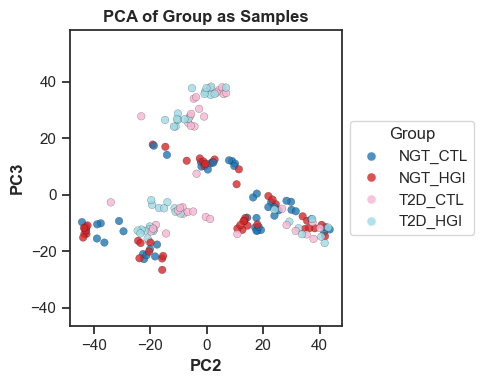

In [20]:
data_df_log_group = data_df_log.join(adata.var['group']).reset_index().set_index('group').drop('index', axis=1)
pc.principal_component_2d_timesample(data=data_df_log_group, x=2, y=3, label='Group', c_map='tab20')

### Step 4: Batch Effects

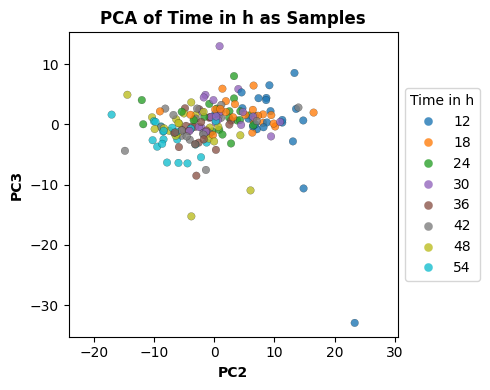

In [6]:
residual_0 = pc.residual_dummy(data=data_df_log.T[data_df_log.mean() > 1].T, data_dummy_1=adata.var['subject'], columns='subject')
residual_time = residual_0.join(adata.var['time']).reset_index().set_index('time').drop('index', axis=1)
pc.principal_component_2d_timesample(data=residual_time, x=2, y=3, label='Time in h', c_map='tab10')

### Step 5: Identify mean and std threshold values

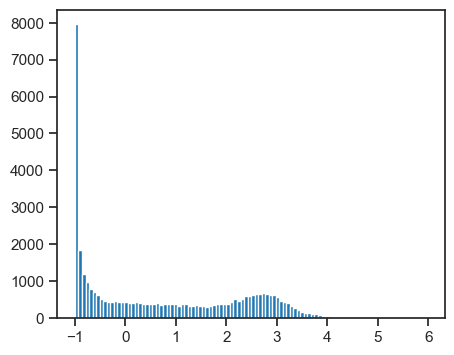

In [87]:
plt.figure(figsize=(5, 4))
plt.hist(x=data_df_log.mean(), bins=100);

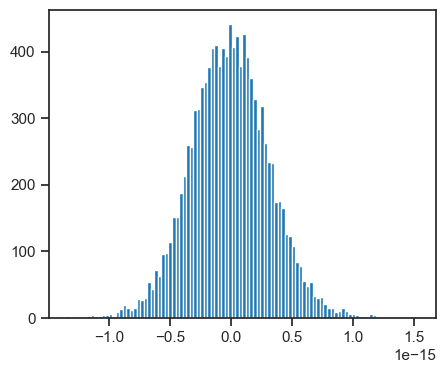

In [253]:
plt.figure(figsize=(5, 4))
plt.hist(x=residual_0.mean(), bins=100);

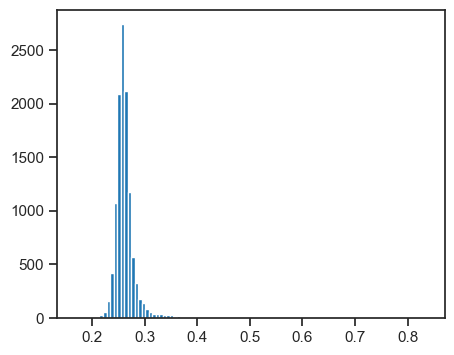

In [254]:
plt.figure(figsize=(5, 4))
plt.hist(x=residual_0.std(), bins=100);

### Step 5: COFE

#### All samples with batch effect

In [63]:
X_train_a = data_df_log
true_time_train_a = adata.var['time'].astype(int)

X_train_a, X_test_a, features_a, features_std_a = COFE.analyse.preprocess_data(X_train_a.to_numpy(), None, 
                                                                           features=X_train_a.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=3)
X_train_a.shape # (Samples, Transcripts)

(172, 9814)

In [25]:
s_choices = np.linspace(1, 50, 15)
cv_a = COFE.analyse.cross_validate(X_train_a, s_choices, features=features_a, K=5, ncores=-1)

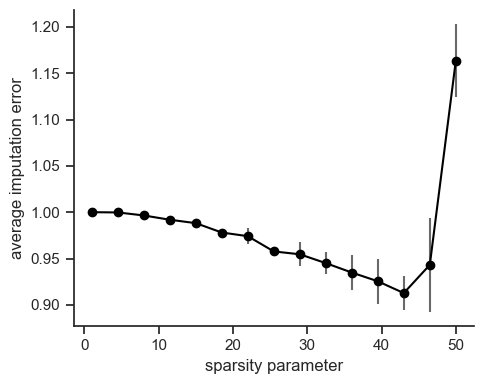

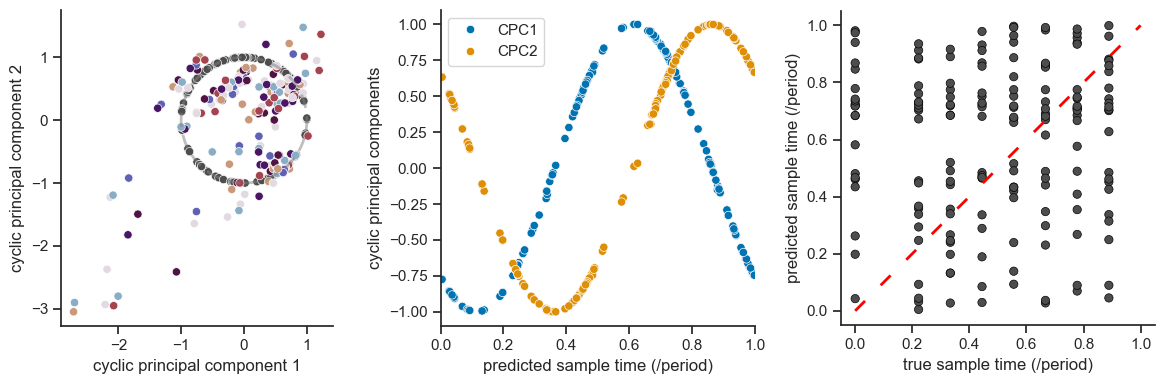

In [26]:
results_train_diet_a = COFE.analyse.predict_time(X_train_a, cv_a, true_times=true_time_train_a.to_numpy(), period=54)
COFE.plot.plot_cv_run(results_train_diet_a, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_a, time=true_time_train_a.to_numpy(), X=X_train_a, figsize=(12, 4), period=54)

#### Only NGT with batch effect

In [ ]:
X_train_b = data_df_log[adata.var['disease'] == 'NGT']
true_time_train_b = adata.var[adata.var['disease'] == 'NGT']['time'].astype(int)

X_train_b, X_test_b, features_b, features_std_b = COFE.analyse.preprocess_data(X_train_b.to_numpy(), None, 
                                                                           features=X_train_b.columns, feature_dim='col', 
                                                                           mean_threshold= 1,scaling_threshold=2.7)
X_train_b.shape # (Samples, Transcripts)

(92, 9546)

In [205]:
s_choices = np.linspace(1, 50, 15)
cv_b = COFE.analyse.cross_validate(X_train_b, s_choices, features=features_b, K=5, ncores=-1)

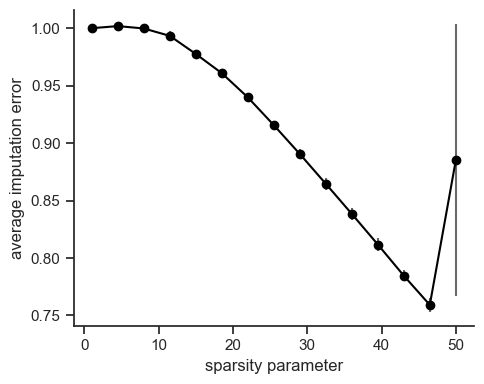

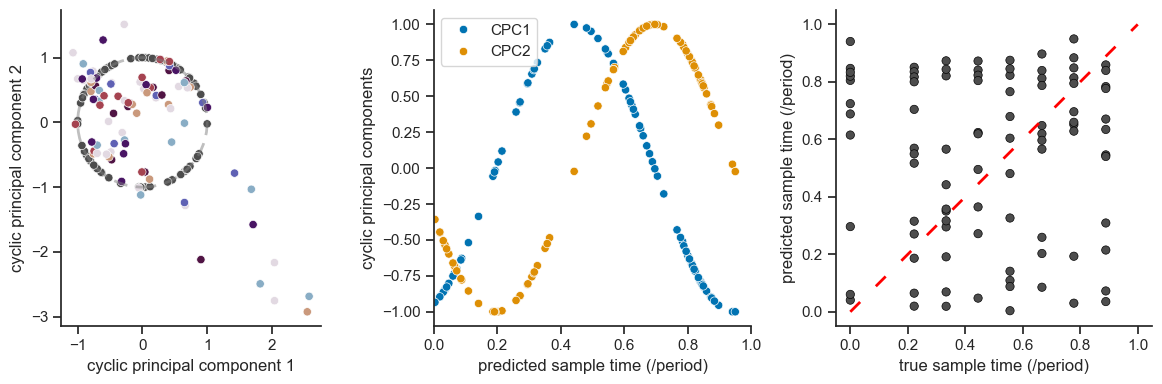

In [206]:
results_train_diet_b = COFE.analyse.predict_time(X_train_b, cv_b, true_times=true_time_train_b.to_numpy(), period=54)
COFE.plot.plot_cv_run(results_train_diet_b, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_b, time=true_time_train_b.to_numpy(), X=X_train_b, figsize=(12, 4), period=54)

#### Only NGT without batch effect

In [7]:
X_train_b = residual_0[adata.var['disease'] == 'NGT']
true_time_train_b = adata.var[adata.var['disease'] == 'NGT']['time'].astype(int)

X_train_b, X_test_b, features_b, features_std_b = COFE.analyse.preprocess_data(X_train_b.to_numpy(), None, 
                                                                           features=X_train_b.columns, feature_dim='col', 
                                                                           mean_threshold= -1, scaling_threshold=3.4)
X_train_b.shape # (Samples, Transcripts)

(92, 4830)

In [8]:
s_choices = np.linspace(1, 50, 15)
cv_b = COFE.analyse.cross_validate(X_train_b, s_choices, features=features_b, K=5, ncores=-1, restarts=10)

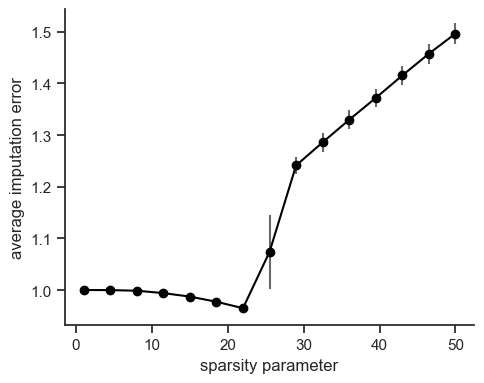

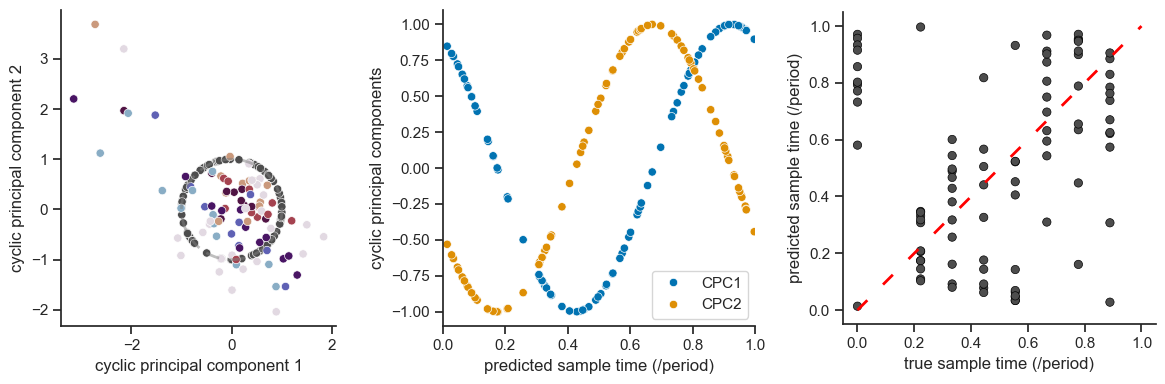

In [9]:
results_train_diet_b = COFE.analyse.predict_time(X_train_b, cv_b, true_times=true_time_train_b.to_numpy(), period=54)
COFE.plot.plot_cv_run(results_train_diet_b, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_b, time=true_time_train_b.to_numpy(), X=X_train_b, figsize=(12, 4), period=54)

In [12]:
results_train_diet_b["MAPE"]*54

np.float64(7.7067173380947285)

#### Only T2D without batch effect

In [243]:
X_train_c = residual_0[adata.var['disease'] == 'T2D']
true_time_train_c = adata.var[adata.var['disease'] == 'T2D']['time'].astype(int)

X_train_c, X_test_c, features_c, features_std_c = COFE.analyse.preprocess_data(X_train_c.to_numpy(), None, 
                                                                           features=X_train_c.columns, feature_dim='col', 
                                                                           mean_threshold= -1,scaling_threshold=4.1)
X_train_c.shape # (Samples, Transcripts)

(80, 8495)

In [244]:
s_choices = np.linspace(1, 50, 15)
cv_c = COFE.analyse.cross_validate(X_train_c, s_choices, features=features_c, K=5, ncores=-1)

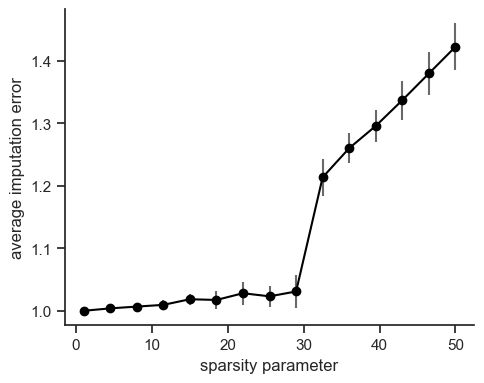

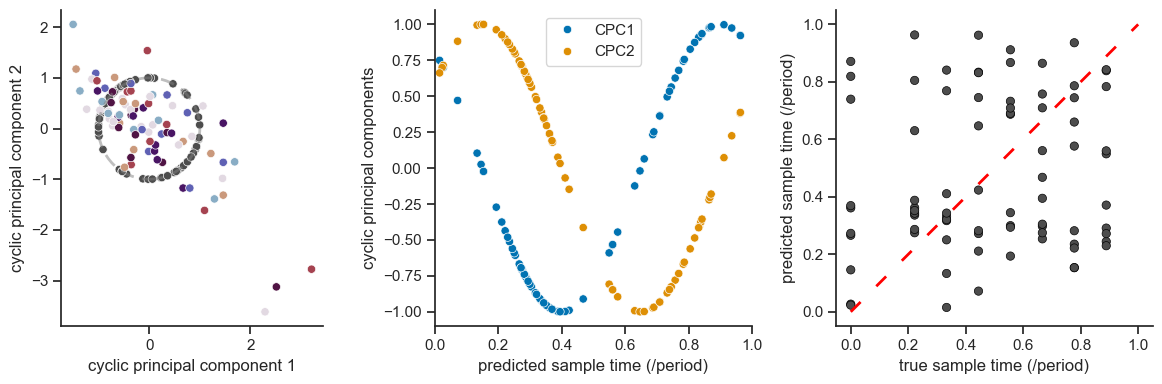

In [245]:
results_train_diet_c = COFE.analyse.predict_time(X_train_c, cv_c, true_times=true_time_train_c.to_numpy(), period=54)
COFE.plot.plot_cv_run(results_train_diet_c, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_c, time=true_time_train_c.to_numpy(), X=X_train_c, figsize=(12, 4), period=54)

In [246]:
results_train_diet_c["MAPE"]*54

np.float64(11.15317588757217)

#### Only one single subject 

In [291]:
X_train_d = data_df_log[adata.var['subject'] == 'i12']
true_time_train_d = adata.var[adata.var['subject'] == 'i12']['time'].astype(int)

X_train_d, X_test_d, features_d, features_std_d = COFE.analyse.preprocess_data(X_train_d.to_numpy(), None, 
                                                                           features=X_train_d.columns, feature_dim='col', 
                                                                           mean_threshold=1,scaling_threshold=5)
X_train_d.shape # (Samples, Transcripts)

(14, 3960)

In [292]:
s_choices = np.linspace(1, 50, 15)
cv_d = COFE.analyse.cross_validate(X_train_d, s_choices, features=features_d, K=5, ncores=-1)

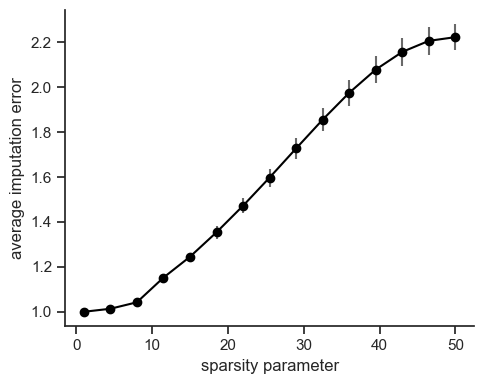

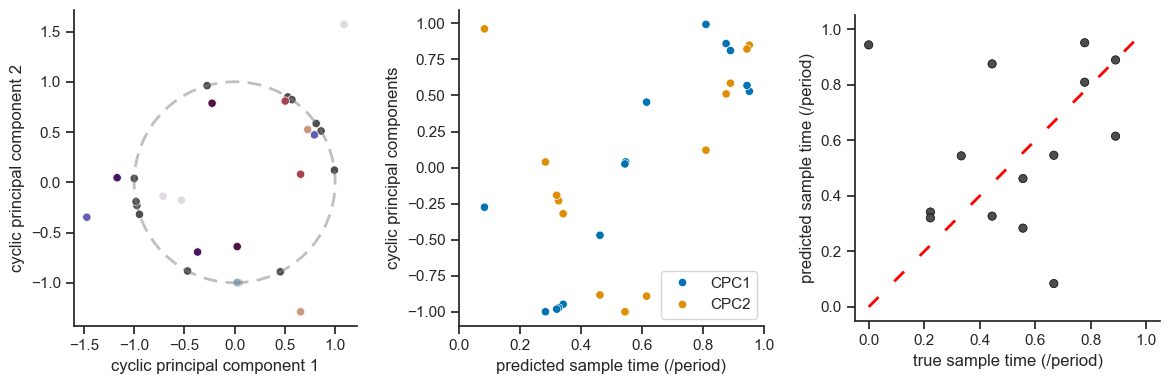

In [293]:
results_train_diet_d = COFE.analyse.predict_time(X_train_d, cv_d, true_times=true_time_train_d.to_numpy(), period=54)
COFE.plot.plot_cv_run(results_train_diet_d, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_d, time=true_time_train_d.to_numpy(), X=X_train_d, figsize=(12, 4), period=54)

In [294]:
results_train_diet_d["MAPE"]*24

np.float64(2.880023686294307)

### Conclusion

COFE has difficulties in predicting time periods for skeletal muscle transcriptomic data over 2 days span. This is likely due to the low amount of rhythmic transcripts and the overall lower amplitude of rhythmic genes that are lost or even truncated during preprocessing of the data. In addition, the amount of expression values is quite variable between subjects, and perhaps even after reducing for batch effect, the variance between individuals is still quite high, leading to noise.

- However, increased sampling frequency, with tissues collected every 2 h for 48 h, and continued development of analysis tools for circadian gene expression studies have expanded this list to more than 2300 genes (http://circadb.org/mouse)

/Users/maksimsgolubovics/Python_VScode/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


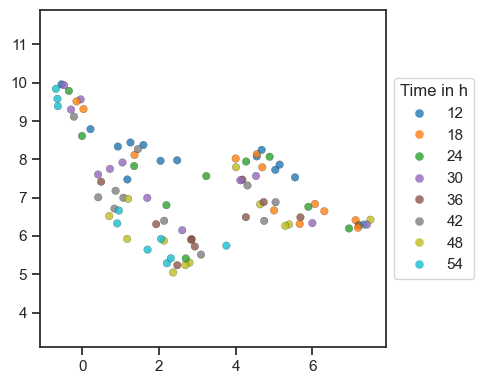

In [307]:
data_df_log_time_un = residual_0[adata.var['disease'] == 'NGT'].join(adata.var['time']).reset_index().set_index('time').drop('index', axis=1)
pc.visualization_of_dec_tools_2d(dec=UMAP(), data=data_df_log_time_un, label='Time in h', c_map='tab10')